# Ablation Study 2: Sequence Length

# Ablation Study 3: Calibration Methods

Here we will compare raw sigmoid outputs, Platt scaling, and isotonic regression calibration for XGBoost receiving yards

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

from data_prep import add_over_under_label, prepare_receiving_sequences
from xgb import XGBTrainConfig, train_xgb_classifier, flatten_sequences
from metrics import compute_ece, compute_pace

train_df = pd.read_csv("data/receiving_2019_2023.csv")
test_df = pd.read_csv("data/receiving_24tocurrent.csv")


STAT_COL    = "YDS"   
LINE_VALUE  = 37.5    
N_PAST_GAMES = 5

train_df = add_over_under_label(
    df=train_df,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    new_col="over_label",
)
test_df = add_over_under_label(
    df=test_df,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    new_col="over_label",
)

X_train, y_train, lengths_train, _ = prepare_receiving_sequences(
    train_df,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)
X_test, y_test, lengths_test, _ = prepare_receiving_sequences(
    test_df,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)


xgb_cfg = XGBTrainConfig(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    verbose=False,
)

xgb_result = train_xgb_classifier(
    X=X_train,
    y=y_train,
    lengths=lengths_train,
    cfg=xgb_cfg,
)

xgb_model = xgb_result["model"]

# Flatten sequences (N, T, E) -> (N, T*E)
X_train_flat = flatten_sequences(X_train)
X_test_flat  = flatten_sequences(X_test)

# Convert y to numpy
if "torch" in str(type(y_train)):
    y_train_np = y_train.detach().cpu().numpy().astype(int)
else:
    y_train_np = np.asarray(y_train, dtype=int)

if "torch" in str(type(y_test)):
    y_test_np = y_test.detach().cpu().numpy().astype(int)
else:
    y_test_np = np.asarray(y_test, dtype=int)


/opt/anaconda3/envs/stock-env/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:40:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [2]:
probs_train_raw = xgb_model.predict_proba(X_train_flat)[:, 1]
probs_test_raw  = xgb_model.predict_proba(X_test_flat)[:, 1]

auc_raw  = roc_auc_score(y_test_np, probs_test_raw)
ece_raw  = compute_ece(y_test_np, probs_test_raw, n_bins=10)
pace_raw = compute_pace(y_test_np, probs_test_raw, L=2, M=2000)

print("=== RAW XGB on TEST ===")
print(f"AUC  : {auc_raw:.4f}")
print(f"ECE  : {ece_raw:.4f}")
print(f"PaCE2: {pace_raw:.44f}  (random 2-leg parlays)\n")

=== RAW XGB on TEST ===
AUC  : 0.7821
ECE  : 0.0132
PaCE2: 0.17767342729867172113067397276608971878886223  (random 2-leg parlays)



In [3]:
platt = LogisticRegression(max_iter=1000)
platt.fit(probs_train_raw.reshape(-1, 1), y_train_np)

probs_test_platt = platt.predict_proba(probs_test_raw.reshape(-1, 1))[:, 1]
probs_test_platt = np.clip(probs_test_platt, 1e-6, 1 - 1e-6)

auc_platt  = roc_auc_score(y_test_np, probs_test_platt)
ece_platt  = compute_ece(y_test_np, probs_test_platt, n_bins=10)
pace_platt = compute_pace(y_test_np, probs_test_platt, L=2, M=2000)

print("=== Platt (Sigmoid) on TEST ===")
print(f"AUC  : {auc_platt:.4f}")
print(f"ECE  : {ece_platt:.4f}")
print(f"PaCE2: {pace_platt:.4f}  (random 2-leg parlays)\n")

=== Platt (Sigmoid) on TEST ===
AUC  : 0.7821
ECE  : 0.0472
PaCE2: 0.1574  (random 2-leg parlays)



In [4]:
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(probs_train_raw, y_train_np)

probs_test_iso = iso.predict(probs_test_raw)
probs_test_iso = np.clip(probs_test_iso, 1e-6, 1 - 1e-6)

auc_iso  = roc_auc_score(y_test_np, probs_test_iso)
ece_iso  = compute_ece(y_test_np, probs_test_iso, n_bins=10)
pace_iso = compute_pace(y_test_np, probs_test_iso, L=2, M=2000)

print("=== Isotonic Regression on TEST ===")
print(f"AUC  : {auc_iso:.4f}")
print(f"ECE  : {ece_iso:.4f}")
print(f"PaCE2: {pace_iso:.4f}  (random 2-leg parlays)\n")


=== Isotonic Regression on TEST ===
AUC  : 0.7808
ECE  : 0.0425
PaCE2: 0.1592  (random 2-leg parlays)



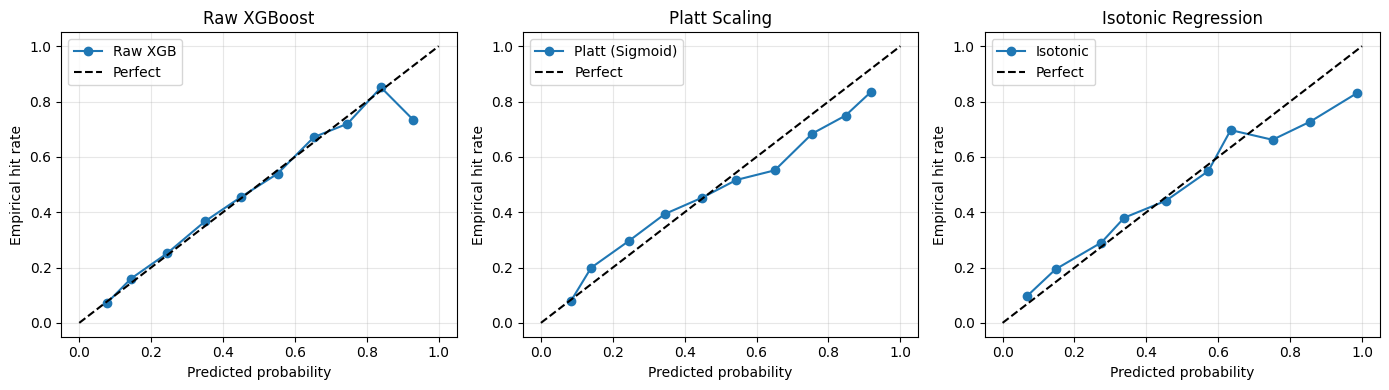

In [5]:
prob_true_raw,   prob_pred_raw   = calibration_curve(y_test_np, probs_test_raw,   n_bins=10, strategy="uniform")
prob_true_platt, prob_pred_platt = calibration_curve(y_test_np, probs_test_platt, n_bins=10, strategy="uniform")
prob_true_iso,   prob_pred_iso   = calibration_curve(y_test_np, probs_test_iso,   n_bins=10, strategy="uniform")

plt.figure(figsize=(14, 4))

ax1 = plt.subplot(1, 3, 1)
ax1.plot(prob_pred_raw, prob_true_raw, "o-", label="Raw XGB")
ax1.plot([0, 1], [0, 1], "k--", label="Perfect")
ax1.set_title("Raw XGBoost")
ax1.set_xlabel("Predicted probability")
ax1.set_ylabel("Empirical hit rate")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(1, 3, 2)
ax2.plot(prob_pred_platt, prob_true_platt, "o-", label="Platt (Sigmoid)")
ax2.plot([0, 1], [0, 1], "k--", label="Perfect")
ax2.set_title("Platt Scaling")
ax2.set_xlabel("Predicted probability")
ax2.set_ylabel("Empirical hit rate")
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Isotonic ---
ax3 = plt.subplot(1, 3, 3)
ax3.plot(prob_pred_iso, prob_true_iso, "o-", label="Isotonic")
ax3.plot([0, 1], [0, 1], "k--", label="Perfect")
ax3.set_title("Isotonic Regression")
ax3.set_xlabel("Predicted probability")
ax3.set_ylabel("Empirical hit rate")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Expectated Calibration Error is actually better on the raw XGBoost model with similar AUC values post calibration